<a href="https://colab.research.google.com/github/cam2149/IntroRecSysDesign/blob/main/MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Paso 1: Descargar el dataset consolidado de Mediaeval para posterior entrenamiento.**

In [ ]:
!wget -O data.csv "http://104.237.5.250/datasets/data.csv"
!ls

--2025-06-11 14:46:59--  http://104.237.5.250/datasets/data.csv
Connecting to 104.237.5.250:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4562229 (4.4M) [text/csv]
Saving to: ‘data.csv’

data.csv            100%[===================>]   4.35M  14.3MB/s    in 0.3s    

2025-06-11 14:47:00 (14.3 MB/s) - ‘data.csv’ saved [4562229/4562229]

data.csv  sample_data


### **Paso 2: Algoritmo para la definición del modelo y optimización**

In [ ]:
import csv
import sys
import traceback
import logging
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
import sklearn
import pickle

data=None
model=None
model_arousal=None
test_predictionsval=None
test_predictionsaro=None
headers=None
data1=None
param_values=None
b=[]
valy=None
arouy=None

# Función encargada de aplicar el PCA
def pca(train,test,val,com):
    print("Ingresa a PCA")
    # Tomado como referencia el código de:
    # https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
    # https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
    # Otra forma de normalizar la matriz por columnas:
    scaler = StandardScaler()
    scaler.fit(train) # Calcula el valor del mean y del std
    datosNuevos = scaler.transform(train) # Aplica la normalización.
    # A continuación se aplica la técnica de PCA.
    # Al crear el PCA se define la cantidad de varianza que se quiere / busca
    # representar a través de componentes. Entre más alta, menor perdida.
    #pca = PCA(n_components=com)
    pca = PCA(0.95)
    pca.fit(train)# Entrena el modelo que permitirá la reducción a través de PCA.
    # Genera la reducción de la matriz por componentes
    # para el dataset de entrenamiento y el de pruebas.
    train_c = pca.transform(train)
    test_c = pca.transform(test)
    return [train_c,test_c]

# Proceso de cargue del archivo con datos de mediaeval
def cargarBD():
    global data
    global headers
    data_path = 'data.csv'

    with open(data_path, 'r') as f:
        reader = csv.reader(f, delimiter=',')
        # Se extrae la cabecera del archivo
        # Corresponde a los nombres de los atributos, arousal, valence, etc.
        headers = next(reader)
        # Se extrae la totalidad de los datos. Todas las canciones y sus features.
        data = list(reader)
        # Los datos son convertidos a objetos de tipo numpy.
        # Esto es indispensable para posteriormente construir el modelo.
        try:
            data = np.array(data).astype(float)
        except ValueError:
            #La excepción maneja errores de lectura sobre el archivo.
            e = sys.exc_info()
            print("Error",e)
            logging.error(traceback.format_exc())
    # Termina proceso de cargue

    # Proceso de normalización de valence y arousal.

    data[:,1]=((data[:,1]-4.5)/9)/0.5

    data[:,2]=((data[:,2]-4.5)/9)/0.5

def mostrarNormalizado():
    # Mostrar datos normalizados
    plt.figure("Mediaeval - Datos normalizados")
    plt.scatter(data[:,1], data[:,2], s=10)
    plt.xlabel('Valence')
    plt.ylabel('Arousal')

    plt.xlim(np.amin(data[:,1]-0.1),np.amax(data[:,1]+0.1))

    plt.ylim(np.amin(data[:,2]-0.1),np.amax(data[:,2]+0.1))

    plt.axhline(0, color='black')
    plt.axvline(0, color='black')

    plt.show()


def modelos(val,entre, pcaflag,tasa,pcaval,bala,com):
    # Se generan estructuras para datos de entrenamiento y de pruebas
    # por features y valores a predecir.

    tamfil=(data.shape[0]-1)

    global train_data, train_labels, train_labels_arousal, test_data,test_labels, test_labels_arousal

    # Datos de entrenamientos.
    train_data= np.array(data[0:int(tamfil*entre),3:])
    train_labels=np.array(data[0:int(tamfil*entre),1])#Valence
    train_labels_arousal=np.array(data[0:int(tamfil*entre),2])#Arousal


    # Datos de pruebas
    test_data= np.array(data[(int(tamfil*entre)):,3:])
    test_labels=np.array(data[(int(tamfil*entre)):,1])#Valence
    test_labels_arousal=np.array(data[(int(tamfil*entre)):,2])#Arousal

    # Proceso de normalización de los datos de entrenamiento
    # La desviación estándar calculada es la poblacional.
    # El valor de la poblacional es menor a la muestral.

    # Se valida si se aplicará pca o no.
    if(pcaflag):
        print("Cumple PCA")
        r=pca(train_data,test_data,pcaval,com)
        train_data=r[0]
        test_data=r[1]
        # Normalizar Componentes
        mean = train_data.mean(axis=0)
        std = train_data.std(axis=0)
        train_data = (train_data - mean) / std
        test_data = (test_data - mean) / std
    else:
        print("No Cumple PCA")
        #
        scaler = StandardScaler()
        # Don't cheat - fit only on training data
        scaler.fit(train_data)
        train_data = scaler.transform(train_data)
        # apply same transformation to test data
        test_data = scaler.transform(test_data)



        # Normalizar todas las features.
        mean = train_data.mean(axis=0)
        std = train_data.std(axis=0)
        train_data = (train_data - mean) / std
        test_data = (test_data - mean) / std


    # Generación del modelo.
    def build_model():
        model = keras.Sequential([keras.layers.Dense(64, activation=tf.nn.relu,
        input_shape=(train_data.shape[1],)),
        keras.layers.Dense(64, activation=tf.nn.relu),
        keras.layers.Dense(1)])
        #optimizer = tf.train.RMSPropOptimizer(tasa)
        optimizer=tf.keras.optimizers.RMSprop(tasa)

        model.compile(loss='mae', optimizer=optimizer)
        return model
    global model
    global model_arousal
    model = build_model() # Modelo para predecir Valence
    model.summary()
    model_arousal = build_model()  # Modelo para predecir Arousal
    model_arousal.summary()


    # Se ejecuta el proceso de entrenamiento con early stop.

    class PrintDot(keras.callbacks.Callback):
      def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

    EPOCHS=50
    #epochs=EPOCHS
    #mean_absolute_error, val_loss
    #early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
    global history
    global history_arousal
    history = model.fit(train_data, train_labels,
                        validation_split=val, verbose=1,epochs=EPOCHS)
                        #callbacks=[early_stop, PrintDot()])

    history_arousal = model_arousal.fit(train_data, train_labels_arousal,
                        validation_split=val, verbose=1,epochs=EPOCHS)
                        #callbacks=[early_stop, PrintDot()])



# Evaluar la efectividad del modelo en consideración al dataset de prueba:

def mae():
    l=[]
    mae = model.evaluate(test_data, test_labels, verbose=0)
    print("Dataset de prueba -  Mean Abs Error en modelo Valence:",mae)

    mae = model_arousal.evaluate(test_data, test_labels_arousal, verbose=0)

    print("Dataset de prueba -  Mean Abs Error en modelo Arousal:",mae)


    return l



def guardarModelos():
    model.save("valencepred.keras")
    model_arousal.save("arousalpred.keras")
    print("Modelo Valence Guardado!")
    print("Modelo Arousal Guardado!")






### **Paso 3: Entrenamiento del modelo**

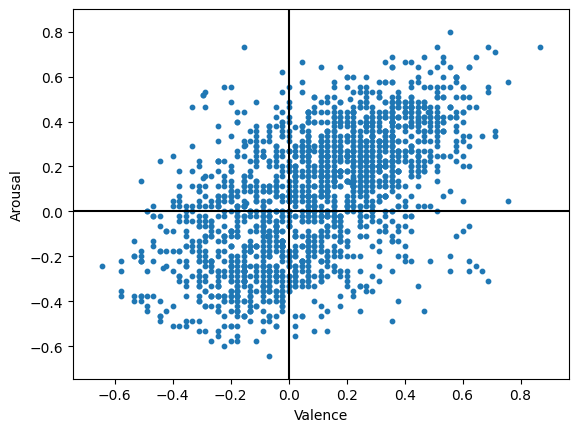

No Cumple PCA


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        16,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,929 (81.75 KB)

 Trainable params: 20,929 (81.75 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │        16,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,929 (81.75 KB)

 Trainable params: 20,929 (81.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3978 - val_loss: 0.2757
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2393 - val_loss: 0.2347
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1805 - val_loss: 0.2371
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1738 - val_loss: 0.1973
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1531 - val_loss: 0.2040
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1413 - val_loss: 0.1951
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1281 - val_loss: 0.1985
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1318 - val_loss: 0.1886
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1247 - val_loss: 0.2150
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1305 - val_loss: 0.1862
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1065 - val_loss: 0.1925
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1098 - val_lo

[]

In [ ]:
cargarBD()
# Mostrar coordenada por canción
mostrarNormalizado()
# Generar el entrenamiento
modelos(0.2,0.8,False,0.001,0.95,False,0)
mae()

### **Paso 4: Guardar los modelos.**

In [ ]:
# Guardar los modelos
guardarModelos()

Modelo Valence Guardado!
Modelo Arousal Guardado!
